<a href="https://colab.research.google.com/github/fatsed/CustomerSupportToneChecker/blob/main/notebooks/02_ToneDetection_api_ui.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1-Load Dataset




In [27]:
!git clone https://github.com/fatsed/CustomerSupportToneChecker.git

Cloning into 'CustomerSupportToneChecker'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 97 (delta 41), reused 37 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (97/97), 147.84 KiB | 1.23 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [28]:
%cd /content/CustomerSupportToneChecker/notebooks

/content/CustomerSupportToneChecker/notebooks


In [37]:
#load dataset
import os
import pandas as pd

BASE_DIR = os.path.abspath("..")
DATA_PATH = os.path.join(BASE_DIR, "dataset", "tone_dataset.csv")

print("BASE_DIR:", BASE_DIR)
print("DATA_PATH:", DATA_PATH)

df = pd.read_csv(DATA_PATH)
print("✅ Dataset loaded.")
print("Shape:", df.shape)
df.head()

BASE_DIR: /content/CustomerSupportToneChecker
DATA_PATH: /content/CustomerSupportToneChecker/dataset/tone_dataset.csv
✅ Dataset loaded.
Shape: (300, 3)


,id,text,label
0,1,سلام وقت بخیر. می‌خواستم وضعیت سفارش شماره ۱۲۳...,polite
1,2,سلام و عرض ادب. لطفاً زمان تقریبی ارسال بسته م...,polite
2,3,با سلام. ممنون می‌شم اگر کد رهگیری را برای بند...,polite
3,4,روزتون بخیر. امکانش هست وضعیت مرسوله را بررسی ...,polite
4,5,سلام. ممنون می‌شم اگر راهنمایی کنید چطور می‌تو...,polite


In [38]:
# Encode labels to numeric (label_id)
label_map = {
    "polite": 0,
    "semi_polite": 1,
    "impolite": 2
}
df["label_id"] = df["label"].map(label_map)
print(df[["id", "text", "label", "label_id"]].head())
print("\nEncoded label counts:")
print(df["label_id"].value_counts())

  id                                               text   label  label_id
0  1  سلام وقت بخیر. می‌خواستم وضعیت سفارش شماره ۱۲۳...  polite         0
1  2  سلام و عرض ادب. لطفاً زمان تقریبی ارسال بسته م...  polite         0
2  3  با سلام. ممنون می‌شم اگر کد رهگیری را برای بند...  polite         0
3  4  روزتون بخیر. امکانش هست وضعیت مرسوله را بررسی ...  polite         0
4  5  سلام. ممنون می‌شم اگر راهنمایی کنید چطور می‌تو...  polite         0

Encoded label counts:
label_id
0    100
1    100
2    100
Name: count, dtype: int64


#2-Preprocessing

In [31]:
!pip install gensim python-crfsuite fasttext flashtext && pip install hazm --no-deps

In [40]:
from hazm import Normalizer, word_tokenize, stopwords_list
import re

normalizer = Normalizer()
stopwords = set(stopwords_list())

def clean_text(text: str) -> str:
    text = str(text)

    # 1) Normalize
    text = normalizer.normalize(text)

    # 2) Remove English letters and numbers (optional but cleaner)
    text = re.sub(r"[A-Za-z0-9۰-۹]", " ", text)
    text = re.sub(r"[^\u0600-\u06FF\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    # 3) Tokenize
    tokens = word_tokenize(text)

    # 4) Remove stopwords + very short tokens
    tokens = [t for t in tokens if t not in stopwords and len(t) > 1]

    # 5) ⚠️ NO STEMMING, NO LEMMATIZATION
    # (چون باعث خراب شدن کلمه‌ها می‌شه)

    return " ".join(tokens)


In [39]:
df["text"] = df["text"].astype(str).str.strip()
df = df.dropna(subset=["text", "label"])
df = df.drop_duplicates(subset=["text", "label"]).reset_index(drop=True)

df["text_clean"] = df["text"].apply(clean_text)

print("✅ Preprocessing done.")
df[["text", "text_clean", "label"]].head(10)


✅ Preprocessing done.


,text,text_clean,label
0,سلام وقت بخیر. می‌خواستم وضعیت سفارش شماره ۱۲۳...,سلام وقت بخیر می‌خواستم وضعیت سفارش شماره بدونم,polite
1,سلام و عرض ادب. لطفاً زمان تقریبی ارسال بسته م...,سلام عرض ادب لطفا زمان تقریبی ارسال بسته منو ا...,polite
2,با سلام. ممنون می‌شم اگر کد رهگیری را برای بند...,سلام ممنون می‌شم کد رهگیری بنده ارسال,polite
3,روزتون بخیر. امکانش هست وضعیت مرسوله را بررسی ...,روزتون بخیر امکانش هست وضعیت مرسوله بررسی,polite
4,سلام. ممنون می‌شم اگر راهنمایی کنید چطور می‌تو...,سلام ممنون می‌شم راهنمایی چطور می‌تونم آدرس اصلاح,polite
5,وقتتون بخیر. اگر زحمتی نیست هزینه ارسال به شیر...,وقتتون بخیر زحمتی هزینه ارسال شیراز می‌فرمایید,polite
6,سلام. مرسی از پشتیبانی خوبتون. فقط یک سوال درب...,سلام مرسی پشتیبانی خوبتون سوال موجودی داشتم,polite
7,سلام. لطفاً مشخصات فنی محصول رو برام ارسال می‌...,سلام لطفا مشخصات فنی محصول برام ارسال می‌کنید,polite
8,درود بر شما. امکانش هست فاکتور خرید رو برام ای...,درود امکانش هست فاکتور خرید برام ایمیل,polite
9,سلام و خسته نباشید. وضعیت سفارش من به‌روزرسانی...,سلام خسته نباشید وضعیت سفارش به‌روزرسانی نشده ...,polite


#3-Feature Extraction

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label_id"] = le.fit_transform(df["label"])
print("Classes:", list(le.classes_))  # ['impolite', 'polite', 'semi_polite'] یا مشابه
X = df["text_clean"].values
y = df["label_id"].values


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train), " | Test size:", len(X_test))

Classes: ['impolite', 'polite', 'semi_polite']
Train size: 240  | Test size: 60


In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_features=5000,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("✅ TF-IDF fitted.")
print("TF-IDF shape:", X_train_tfidf.shape)

✅ TF-IDF fitted.
TF-IDF shape: (240, 307)


In [48]:
feature_names = tfidf.get_feature_names_out()
print("Total features:", len(feature_names))
print("نمونه‌ای از چند ویژگی اول:")
print(feature_names[:30])

Total features: 307
نمونه‌ای از چند ویژگی اول:
['آزاردهنده' 'آزاردهنده ست' 'ادامه' 'ارسال' 'ارسال اعلام' 'ارسال انجام'
 'ارسال شده' 'ارسال طولانی' 'ارسال فوری' 'ارسال ممنون' 'ارسال می'
 'ارسال نشده' 'استفاده' 'اشتباه' 'اشتباه ارسال' 'اشتباه ثبت' 'اشتباهه'
 'اشتباهی' 'اصلا' 'اصلا درست' 'اصلا پیام' 'اصلاح' 'اصلاحش' 'اطلاع'
 'اطلاع بدید' 'اطلاع رسانی' 'اطلاعات' 'اطلاعات اشتباه' 'اعلام' 'امروز']


# 4-Model Training

In [51]:
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
print("✔ SVM model trained successfully.")

✔ SVM model trained successfully.


In [52]:
y_pred = svm_model.predict(X_test_tfidf)
print("Predictions done.")

Predictions done.


In [53]:
#Evaluation
from sklearn.metrics import accuracy_score, classification_report

acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy (SVM): {acc:.4f}\n")
print("Classification Report (SVM):")
print(classification_report(
    y_test,
    y_pred,
    target_names=le.classes_
))


Accuracy (SVM): 0.9333

Classification Report (SVM):
              precision    recall  f1-score   support

    impolite       0.87      1.00      0.93        20
      polite       0.95      1.00      0.98        20
 semi_polite       1.00      0.80      0.89        20

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



Confusion Matrix (SVM)

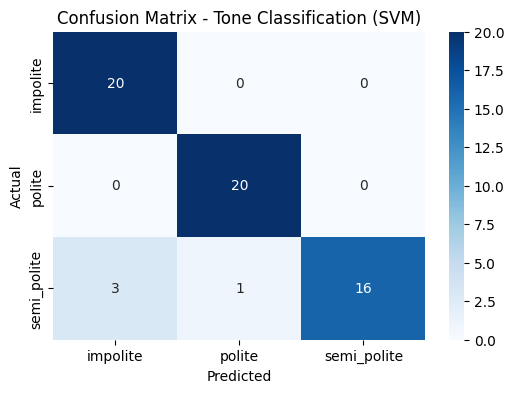

In [54]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    cmap="Blues",
    fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Tone Classification (SVM)")
plt.show()

In [82]:
#Train & Compare Multiple Models (SVM / LR / RF / DT)
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support

models_dict = {
    "SVM (LinearSVC)": LinearSVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
}

In [57]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )
    return model, acc, precision, recall, f1

In [59]:
import pandas as pd

results = []
trained_models = {}

for name, model in models_dict.items():
    print(f"🔹 Training model: {name} ...")
    fitted_model, acc, prec, rec, f1 = train_and_evaluate(
        model, X_train_tfidf, y_train, X_test_tfidf, y_test
    )
    trained_models[name] = fitted_model
    results.append({
        "model": name,
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1
    })

results_df = pd.DataFrame(results).sort_values(
    by="accuracy",
    ascending=False
).reset_index(drop=True)

print("\n📊 مقایسه عملکرد مدل‌ها:\n")
results_df

🔹 Training model: SVM (LinearSVC) ...
🔹 Training model: Logistic Regression ...
🔹 Training model: Random Forest ...
🔹 Training model: Decision Tree ...

📊 مقایسه عملکرد مدل‌ها:



,model,accuracy,precision_macro,recall_macro,f1_macro
0,SVM (LinearSVC),0.933333,0.940649,0.933333,0.931577
1,Logistic Regression,0.933333,0.940649,0.933333,0.931577
2,Random Forest,0.883333,0.906410,0.883333,0.881032
3,Decision Tree,0.833333,0.870635,0.833333,0.836862


In [61]:
id2label = {i: c for i, c in enumerate(le.classes_)}  # 0→impolite, ...
label2fa = {
    "polite": "مودبانه",
    "semi_polite": "نیمه‌مودبانه",
    "impolite": "غیرمودبانه",
}
# مدل فعال پیش‌فرض (می‌تونی عوضش کنی)
active_model_name = "Logistic Regression"
active_model = trained_models[active_model_name]
print("مدل فعال فعلی:", active_model_name)

مدل فعال فعلی: Logistic Regression


In [63]:
def predict_tone(text: str, model_name: str = None):
    """
    ورودی:
      - text: متن خام پیام مشتری (فارسی)
      - model_name (اختیاری): نام مدلی مثل "SVM (LinearSVC)" یا "Random Forest"
    خروجی:
      - model_used: نام مدل استفاده‌شده
      - label_en: یکی از ['polite', 'semi_polite', 'impolite']
      - label_fa: معادل فارسی (مودبانه / نیمه‌مودبانه / غیرمودبانه)
    """
    if model_name is None:
        model = active_model
        model_used = active_model_name
    else:
        model = trained_models.get(model_name, active_model)
        model_used = model_name

    text_clean = clean_text(text)
    x_vec = tfidf.transform([text_clean])
    pred_id = model.predict(x_vec)[0]

    label_en = id2label[pred_id]
    label_fa = label2fa[label_en]
    return model_used, label_en, label_fa

#test
test_text = "این چه وضعشه؟ چند روزه معطل سفارشم هستم!"
for name in trained_models.keys():
    m_name, en, fa = predict_tone(test_text, model_name=name)
    print(f"مدل: {m_name} → {en} / {fa}")

مدل: SVM (LinearSVC) → impolite / غیرمودبانه
مدل: Logistic Regression → impolite / غیرمودبانه
مدل: Random Forest → impolite / غیرمودبانه
مدل: Decision Tree → impolite / غیرمودبانه


In [85]:
# === Save trained models (SVM, Logistic, RF, DT)
import joblib
import os

MODELS_DIR = os.path.join(BASE_DIR, "models")
os.makedirs(MODELS_DIR, exist_ok=True)

joblib.dump(tfidf, os.path.join(MODELS_DIR, "tfidf_vectorizer.pkl"))
for name, model in trained_models.items():
    file_name = name.lower().replace(" ", "_").replace("(", "").replace(")", "") + ".pkl"
    save_path = os.path.join(MODELS_DIR, file_name)
    joblib.dump(model, save_path)
    print("✔ ذخیره شد:", save_path)


✔ ذخیره شد: /content/CustomerSupportToneChecker/models/svm_linearsvc.pkl
✔ ذخیره شد: /content/CustomerSupportToneChecker/models/logistic_regression.pkl
✔ ذخیره شد: /content/CustomerSupportToneChecker/models/random_forest.pkl
✔ ذخیره شد: /content/CustomerSupportToneChecker/models/decision_tree.pkl


# 5-Evaluation

In [ ]:
#Evaluation & Error Analysis

In [68]:
#Build test_df with true & predicted labels
model_for_eval = trained_models["Logistic Regression"]

y_pred_eval = model_for_eval.predict(X_test_tfidf)

acc_eval = accuracy_score(y_test, y_pred_eval)
print(f"Accuracy ({model_for_eval.__class__.__name__}): {acc_eval:.4f}")

# DataFrame برای تحلیل خطا
test_df = pd.DataFrame({
    "text": X_test,
    "y_true": y_test,
    "y_pred": y_pred_eval,
})

test_df["true_label"] = test_df["y_true"].map(id2label)
test_df["pred_label"] = test_df["y_pred"].map(id2label)

Accuracy (LogisticRegression): 0.9333


In [69]:
#Extract misclassified examples
errors = test_df[test_df["y_true"] != test_df["y_pred"]].copy()
print("تعداد کل نمونه‌های تست:", len(test_df))
print("تعداد خطاها:", len(errors))
print("نرخ خطا:", round(len(errors) / len(test_df), 3))

errors[["text", "true_label", "pred_label"]].head(10)

تعداد کل نمونه‌های تست: 60
تعداد خطاها: 4
نرخ خطا: 0.067


,text,true_label,pred_label
17,روزه منتظر هستم تغییری نمی‌بینم,semi_polite,impolite
36,گفته_بودید موجوده الان می‌گید موجود,semi_polite,impolite
40,ممنون می‌شم آدرس صحیح تأیید,semi_polite,polite
49,ممکنه راهنمایی چطور لغو,semi_polite,impolite


In [70]:
#Group errors by (true_label, pred_label)
error_groups = errors.groupby(["true_label", "pred_label"]).size().reset_index(name="count")
print("\nگروه‌بندی خطاها:")
print(error_groups)



گروه‌بندی خطاها:
    true_label pred_label  count
0  semi_polite   impolite      3
1  semi_polite     polite      1


In [71]:
#Show some typical errors for each confusion case
def show_errors(true_label, pred_label, n=5):
    subset = errors[(errors["true_label"] == true_label) &
                    (errors["pred_label"] == pred_label)]
    print(f"\n=== واقعی: {true_label} | پیش‌بینی: {pred_label} | تعداد: {len(subset)} ===")
    for _, row in subset.head(n).iterrows():
        print("• متن:", row["text"])
        print("---")

show_errors("polite", "semi_polite", n=5)
show_errors("semi_polite", "polite", n=5)
show_errors("semi_polite", "impolite", n=5)
show_errors("impolite", "semi_polite", n=5)


=== واقعی: polite | پیش‌بینی: semi_polite | تعداد: 0 ===

=== واقعی: semi_polite | پیش‌بینی: polite | تعداد: 1 ===
• متن: ممنون می‌شم آدرس صحیح تأیید
---

=== واقعی: semi_polite | پیش‌بینی: impolite | تعداد: 3 ===
• متن: روزه منتظر هستم تغییری نمی‌بینم
---
• متن: گفته_بودید موجوده الان می‌گید موجود
---
• متن: ممکنه راهنمایی چطور لغو
---

=== واقعی: impolite | پیش‌بینی: semi_polite | تعداد: 0 ===


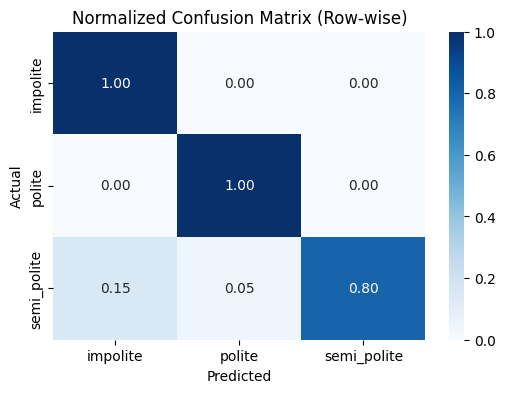

In [72]:
#Normalized confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_eval)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_norm,
    annot=True,
    cmap="Blues",
    fmt=".2f",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix (Row-wise)")
plt.show()

# 6-UI


In [74]:
# 6- Inference & Simple CLI UI

print("سیستم تشخیص لحن پیام‌های پشتیبانی مشتری")
print("متن پیام را وارد کنید. برای خروج، q را وارد کنید.")
print("-" * 60)

while True:
    msg = input("پیام مشتری: ")
    if msg.strip().lower() == "q":
        print("خروج از سیستم.")
        break

    model_used, en, fa = predict_tone(msg)
    print("لحن تشخیص داده‌شده:")
    print(" - مدل:", model_used)
    print(" - انگلیسی:", en)
    print(" - فارسی :", fa)
    print("-" * 60)

سیستم تشخیص لحن پیام‌های پشتیبانی مشتری
متن پیام را وارد کنید. برای خروج، q را وارد کنید.
------------------------------------------------------------
پیام مشتری: q
خروج از سیستم.


#Gradio UI + HuggingFace API

In [75]:
# 7- Gradio UI (API Level)

!pip install gradio -q

import gradio as gr
import requests

In [84]:
import joblib
import os

MODELS_DIR = os.path.join(BASE_DIR, "models")

tfidf = joblib.load(os.path.join(MODELS_DIR, "tfidf_vectorizer.pkl"))

trained_models = {
    "SVM (LinearSVC)": joblib.load(os.path.join(MODELS_DIR, "svm_linearsvc.pkl")),
    "Logistic Regression": joblib.load(os.path.join(MODELS_DIR, "logistic_regression.pkl")),
    "Random Forest": joblib.load(os.path.join(MODELS_DIR, "random_forest.pkl")),
    "Decision Tree": joblib.load(os.path.join(MODELS_DIR, "decision_tree.pkl")),
}

In [76]:
# ===== 7.2 HuggingFace API setup (temporary KEY handling) =====

HF_API_URL = "https://api-inference.huggingface.co/models/HooshvareLab/bert-fa-base-uncased-sentiment-snappfood"
HF_API_KEY = ""  # با دکمه‌ی Update در UI تنظیم می‌شود

def set_hf_key(new_key: str):
    """
    به‌روزرسانی کلید موقت HuggingFace.
    """
    global HF_API_KEY
    HF_API_KEY = new_key.strip()
    if HF_API_KEY:
        return "✅ کلید با موفقیت به‌روزرسانی شد."
    else:
        return "⚠️ کلید خالی است. لطفاً یک توکن معتبر وارد کنید."

def hf_predict_raw(text: str):
    """
    فراخوانی مستقیم API هاگینگ‌فیس.
    خروجی خام مدل را برمی‌گرداند.
    """
    if not HF_API_KEY:
        return None, "❌ هیچ API Key تنظیم نشده. لطفاً ابتدا کلید را وارد و دکمه «Update Key» را بزنید."

    headers = {"Authorization": f"Bearer {HF_API_KEY}"}
    payload = {"inputs": text}

    try:
        response = requests.post(HF_API_URL, headers=headers, json=payload, timeout=30)
        if response.status_code != 200:
            return None, f"❌ خطا از سمت HuggingFace: {response.status_code} - {response.text}"
        data = response.json()
        return data, None
    except Exception as e:
        return None, f"❌ خطا در ارتباط با API: {e}"

In [77]:
def map_hf_to_tone(hf_output):
    """
    فرض: مدل خروجی‌ای شبیه POSITIVE / NEGATIVE / NEUTRAL یا LABEL_0/1/2 دارد.
    آن را به polite / semi_polite / impolite نگاشت می‌کنیم.
    """
    try:
        # ساختار خیلی از مدل‌ها: [[{"label": "...", "score": ...}, ...]]
        first = hf_output[0][0]
        label = str(first["label"]).upper()
    except Exception:
        return "semi_polite", "نیمه‌مودبانه"  # حالت امن

    # حالت برچسب‌های متنی
    if "POSITIVE" in label:
        return "polite", "مودبانه"
    if "NEGATIVE" in label:
        return "impolite", "غیرمودبانه"
    if "NEUTRAL" in label:
        return "semi_polite", "نیمه‌مودبانه"

    # حالت LABEL_0 / LABEL_1 / LABEL_2 (مثال)
    if "LABEL_0" in label:
        return "polite", "مودبانه"
    if "LABEL_1" in label:
        return "semi_polite", "نیمه‌مودبانه"
    if "LABEL_2" in label:
        return "impolite", "غیرمودبانه"

    # پیش‌فرض
    return "semi_polite", "نیمه‌مودبانه"

In [78]:
def predict_tone_hf(text: str):
    hf_data, error = hf_predict_raw(text)
    if error:
        return "HuggingFace API", error

    en, fa = map_hf_to_tone(hf_data)
    return "HuggingFace API", f"لحن (EN): {en} | (FA): {fa}"

In [79]:
#Main Gradio inference function
def gradio_predict(user_text, task, model_choice):
    if not user_text or user_text.strip() == "":
        return "لطفاً یک متن وارد کنید."

    # فعلاً فقط Classification پیاده‌سازی شده
    if task != "Classification (Tone Detection)":
        return "⚠️ فعلاً فقط بخش «تشخیص لحن پیام پشتیبانی» پیاده‌سازی شده است."

    # اگر مدل HuggingFace انتخاب شده
    if model_choice == "HuggingFace (API)":
        model_name, result = predict_tone_hf(user_text)
        return f"[{model_name}] → {result}"

    # مدل‌های داخلی (SVM, LR, RF, DT)
    model = trained_models.get(model_choice)
    if model is None:
        return "❌ مدل انتخاب‌شده پیدا نشد."

    text_clean = clean_text(user_text)
    vec = tfidf.transform([text_clean])
    pred_id = model.predict(vec)[0]

    label_en = id2label[pred_id]
    label_fa = label2fa[label_en]

    return f"مدل: {model_choice}\nلحن (EN): {label_en}\nلحن (FA): {label_fa}"

In [81]:
#Gradio Blocks UI
task_options = [
    "Classification (Tone Detection)",
    "Spam Detection (Coming Soon)",
    "Translation (Coming Soon)",
]

model_options = list(trained_models.keys()) + ["HuggingFace (API)"]

with gr.Blocks(title="Special Topics - NLP Project") as demo:
    # ---------- صفحه ۱: Welcome ----------
    with gr.Column(visible=True) as page1:
        gr.Markdown("## درس مباحث ویژه – استاد زاغری")
        gr.Markdown("### پروژه: سیستم تشخیص لحن پیام‌های پشتیبانی مشتری")
        gr.Markdown("**نام دانشجو: فاطمه صديقی‌زاده**")
        gr.Markdown("برای ادامه، روی دکمه زیر کلیک کنید.")
        btn_next = gr.Button("Next ▶️")

    # ---------- صفحه ۲: UI اصلی ----------
    with gr.Column(visible=False) as page2:
        gr.Markdown("## 🧠 Customer Support Tone Checker (فارسی)")
        gr.Markdown("در این بخش می‌توانید متن مشتری را وارد کنید، تسک و مدل را انتخاب کنید و لحن را ببینید.")

        with gr.Row():
            task_dd = gr.Radio(task_options, value="Classification (Tone Detection)", label="Task / نوع کار")
            model_dd = gr.Dropdown(model_options, value="SVM (LinearSVC)", label="Model / نوع مدل")

        # بخش API Key
        gr.Markdown("---")
        gr.Markdown("### 🔐 HuggingFace API Key (برای مدل‌های آنلاین – کلید موقت و قابل‌به‌روزرسانی)")
        with gr.Row():
            hf_key_box = gr.Textbox(
                label="HuggingFace API Key",
                type="password",
                placeholder="توکن موقت HuggingFace را اینجا وارد کنید..."
            )
            hf_key_btn = gr.Button("Update Key 🔄")
        hf_key_status = gr.Markdown("وضعیت کلید: هنوز تنظیم نشده است.")

        # ورودی متن و خروجی
        gr.Markdown("---")
        user_text = gr.Textbox(
            lines=4,
            label="متن پیام مشتری (فارسی)",
            placeholder="مثال: سلام وقت بخیر، میشه وضعیت سفارشم رو بگید؟"
        )
        run_btn = gr.Button("تشخیص لحن 🚀")
        output_box = gr.Textbox(label="نتیجه", lines=5)

        # رویدادها
        def go_next():
            return gr.update(visible=False), gr.update(visible=True)

        btn_next.click(fn=go_next, inputs=None, outputs=[page1, page2])

        hf_key_btn.click(
            fn=set_hf_key,
            inputs=hf_key_box,
            outputs=hf_key_status
        )

        run_btn.click(
            fn=gradio_predict,
            inputs=[user_text, task_dd, model_dd],
            outputs=output_box
        )

demo.launch(share=False)  # اگر لینک public بخوای: share=True

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>